In [2]:
import os
import numpy as np
from dataclasses import dataclass
import gen_models
import matplotlib.pyplot as plt
import einops
from meta_transformer import module_path, torch_utils
from jax import flatten_util

@dataclass
class Args:
    d_model = 1024
    dropout_rate = 0.05
    use_embedding = True
    ndata = 100
    chunk_size = 1024

args = Args()

/home/lauro/.virtualenvs/meta-models/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
DATASET = "CIFAR10"  # either MNIST, CIFAR10, or SVHN

In [8]:
# load SVHN model checkpoints
SVHN_PATH = os.path.join(module_path, 'data/david_backdoors/svhn')
CIFAR10_PATH = os.path.join(module_path, 'data/david_backdoors/cifar10')
MNIST_PATH = os.path.join(module_path, 'data/david_backdoors/mnist/models')

if DATASET == "SVHN":
    PATH = SVHN_PATH
    inputs_dirname = "poison_6x6"
elif DATASET == "CIFAR10":
    PATH = CIFAR10_PATH
    inputs_dirname = "poison_easy"
elif DATASET == "MNIST":
    PATH = MNIST_PATH
    inputs_dirname = "poison"

if DATASET == "MNIST":
    architecture = torch_utils.CNNSmall()
else:
    architecture = torch_utils.CNNMedium()  # for CIFAR-10
checkpoints_poisoned, checkpoints_clean, get_pytorch_model = torch_utils.load_input_and_target_weights(
    model=architecture,
    num_models=args.ndata, 
    data_dir=PATH,
    inputs_dirname=inputs_dirname,
    targets_dirname="clean"
)

In [9]:
!ls $CIFAR10_PATH
!ls $SVHN_PATH

arch.py  clean	poison_box  poison_easy  readme.txt  rename.py
arch.py  clean	poison_6x6


In [10]:
# load SVHN
cfg = gen_models.config.Config()

if DATASET == "SVHN":
    data_td = torch_utils.load_svhn_test_data()
elif DATASET == "CIFAR10":
    data_td = torch_utils.load_cifar10_test_data()
elif DATASET == "MNIST":
    data_td = torch_utils.load_mnist_test_data()

data_poisoned_td = gen_models.poison.poison_set(data_td, train=False, cfg=cfg)

data, labels                   = data_td.tensors
data_poisoned, labels_poisoned = data_poisoned_td.tensors

100%|██████████| 9912422/9912422 [00:00<00:00, 11695937.07it/s]


Extracting /home/lauro/projects/meta-models/meta-transformer/data/MNIST/raw/train-images-idx3-ubyte.gz to /home/lauro/projects/meta-models/meta-transformer/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 20172471.91it/s]


Extracting /home/lauro/projects/meta-models/meta-transformer/data/MNIST/raw/train-labels-idx1-ubyte.gz to /home/lauro/projects/meta-models/meta-transformer/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 11449032.95it/s]


Extracting /home/lauro/projects/meta-models/meta-transformer/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/lauro/projects/meta-models/meta-transformer/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22074772.62it/s]

Extracting /home/lauro/projects/meta-models/meta-transformer/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/lauro/projects/meta-models/meta-transformer/data/MNIST/raw



## Run base CNNs

In [12]:
# Clean classifier on clean data
model = get_pytorch_model(checkpoints_clean[42])
model.to("cuda")
model_pois = get_pytorch_model(checkpoints_poisoned[42])
model_pois.to("cuda")

ndata = 10000

print("Testing clean model.")

print("Acc on clean data: ", end="")
print(torch_utils.get_accuracy(model, data[:ndata], labels[:ndata]))

print("Acc on poisoned data: ", end="")
print(torch_utils.get_accuracy(model, data_poisoned[:ndata], labels[:ndata]))

Testing clean model.
Acc on clean data: 0.9764
Acc on poisoned data: 0.9753


In [14]:
print("Testing poisoned model.")

print("Accuracy on clean data: ", end="")
print(torch_utils.get_accuracy(model_pois, data[:ndata], labels[:ndata]))

print("Accuracy on poisoned data: ", end="")
print(torch_utils.get_accuracy(model_pois, data_poisoned[:ndata], labels[:ndata]))

Testing poisoned model.
Accuracy on clean data: 0.9645
Accuracy on poisoned data: 0.9983


## Plot

In [8]:
def normalize_image(image):
    """Normalize an image to [0, 1] for plotting."""
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)


(10000, 3, 32, 32)
tensor(2, device='cuda:0')


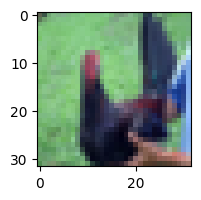

In [9]:
# plot
# first convert to nunmpy and use einops to convert to channels last
# then plot
i = 25
img_data = data.to('cpu')
img_data = img_data.numpy()
print(img_data.shape)
#img_data = einops.rearrange('b c h w -> b h w c', img_data)
img_data = img_data.transpose((0, 2, 3, 1))  # Equivalent to 'b c h w -> b h w c'
plt.figure(figsize=[2,2])
plt.imshow(normalize_image(img_data[i]))
print(labels[i])

(10000, 3, 32, 32)
tensor(2, device='cuda:0')


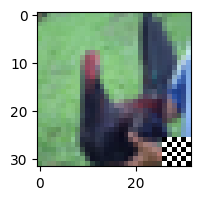

In [10]:
# plot
# first convert to nunmpy and use einops to convert to channels last
# then plot
i = 25
img_data = data_poisoned.to('cpu')
img_data = img_data.numpy()
print(img_data.shape)
#img_data = einops.rearrange('b c h w -> b h w c', img_data)
img_data = img_data.transpose((0, 2, 3, 1))  # Equivalent to 'b c h w -> b h w c'
plt.figure(figsize=[2,2])
plt.imshow(normalize_image(img_data[i]))
print(labels[i])